# Seminar Notebook 1.4: Word Clouds and Weighting

**LSE MY459: Computational Text Analysis and Large Language Models** (WT 2026)

**Ryan Hübert**

This notebook covers word clouds and DFM weighting.

## Directory management

We begin with some directory management to specify the file path to the folder on your computer where you wish to store data for this notebook.

In [2]:
import os
sdir = os.path.join(os.path.expanduser("~"), "LSE-MY459-WT26", "SeminarWeek02") # or whatever path you want
if not os.path.exists(sdir):
    os.mkdir(sdir)

### Loading the DFM

We need to load the DFM we created in the last notebook. We start by reading the sparse array object we saved as an `.npz` file:

In [3]:
from scipy import sparse

sparse_dfm_file = os.path.join(sdir, 'tweet-dfm-sparse.npz')
if os.path.exists(sparse_dfm_file):
    dfm_sparse = sparse.load_npz(sparse_dfm_file)
else:
    raise Exception

print(dfm_sparse)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 50274 stored elements and shape (3866, 5949)>
  Coords	Values
  (0, 96)	1.0
  (0, 151)	1.0
  (0, 883)	1.0
  (0, 1200)	1.0
  (0, 2533)	1.0
  (0, 3470)	1.0
  (0, 3544)	1.0
  (0, 4404)	1.0
  (0, 5424)	1.0
  (0, 5876)	1.0
  (0, 5881)	1.0
  (1, 96)	1.0
  (1, 209)	1.0
  (1, 381)	1.0
  (1, 660)	1.0
  (1, 881)	1.0
  (1, 1130)	1.0
  (1, 2943)	1.0
  (1, 3881)	1.0
  (1, 4732)	1.0
  (2, 590)	1.0
  (2, 595)	1.0
  (2, 881)	1.0
  (2, 1200)	1.0
  (2, 2533)	1.0
  :	:
  (3864, 2922)	1.0
  (3864, 3570)	1.0
  (3864, 3833)	1.0
  (3864, 3880)	1.0
  (3864, 4236)	1.0
  (3864, 4940)	1.0
  (3864, 4941)	1.0
  (3864, 5422)	1.0
  (3864, 5436)	1.0
  (3864, 5764)	1.0
  (3864, 5925)	1.0
  (3865, 261)	1.0
  (3865, 746)	1.0
  (3865, 1226)	1.0
  (3865, 1681)	1.0
  (3865, 1802)	1.0
  (3865, 3691)	1.0
  (3865, 3752)	1.0
  (3865, 4153)	1.0
  (3865, 4470)	1.0
  (3865, 4514)	1.0
  (3865, 4641)	1.0
  (3865, 4985)	1.0
  (3865, 5315)	1.0
  (3865, 5882)	1.0


Next, let's load the list of features (the vocabulary), which remember is not included with the sparse array data:

In [4]:
features_file = os.path.join(sdir, 'tweet-dfm-features.txt')
vocabulary = open(features_file, mode = "r").read().split("\n")
print(vocabulary)

['#afghanistan', '#afghanstrategy', '#ahca', '#alconv2017', '#amazonwashingtonpost', '#america', '#americafirst', '#americafirst🇺🇸#unga', '#americanheroes', '#anthem', '#apec', '#apec2017', '#armedforcesday', '#armynavygame', '#asean50', '#aseansummit', '#autismawarenessday', '#az08', '#balticsummit', '#bastilleday', '#bombers', '#breakingnews', '#brussels', '#buildthewall', '#buyamericanhireamerican', '#bye-bye', '#cajunnavy', '#canada150', '#cashinin', '#ceotownhall', '#cg227', '#cgacommencement17', '#chagsameach', '#changethelaws', '#charliegard', '#charlot', '#charlottesville', '#columbusday', '#confirmgina', '#confirmgorsuch', '#congratspeggy', '#congressionalbaseballgame', '#congressionalgoldmedal', '#cpac2018', '#crookedhillary', '#davos2018', '#dday', '#democrat', '#democratshutdown', '#dobbs', '#dod', '#dow', '#dow23k', '#dow24k', '#dprk', '#draintheswam', '#draintheswamp', '#dts', '#earnhistory', '#endingwaroncoal', '#energyweek', '#entrepreneurs', '#faithandfreedom', '#fake'

Finally, we'll load the corpus that we saved, which contains the date and time of each tweet, which we may need to identify tweets in our DFM.

In [5]:
import pandas as pd

corpus_file = os.path.join(sdir, "tweet-corpus.csv")
corpus = pd.read_csv(corpus_file)
corpus["datetime"].head()
corpus["datetime"] = pd.to_datetime(corpus["datetime"]).dt.tz_convert("US/Eastern") # Convert to US Eastern time

## Top features

Let's calculate the top features of our DFM. Begin by summing across the rows of the DFM:

In [6]:
top_features = dfm_sparse.sum(axis = 0).A1
top_features

array([1., 1., 1., ..., 1., 4., 1.], shape=(5949,))

This tells us that the first three features appears 1 time in the corpus, the second to last feature appears 4 times, etc. We're looking at the sums across the rows of the DFM, but what are these features? That is, what column names correspond to each of these? Let's reformat to a nicer looking table using the list of features we read as the `vocabulary` object:

In [7]:
top_features = pd.Series(top_features, index=vocabulary)
top_features

#afghanistan             1.0
#afghanstrategy          1.0
#ahca                    1.0
#alconv2017              2.0
#amazonwashingtonpost    1.0
                        ... 
zito                     1.0
zone                     5.0
zoo                      1.0
zte                      4.0
zuker                    1.0
Length: 5949, dtype: float64

Finally, let's do a little clean up: reformat the counts as integers and arrange in descending order.

In [8]:
top_features = top_features.astype(int)
top_features = top_features.sort_values(ascending=False)
top_features[0:20]

great       831
rt          419
peopl       390
countri     323
news        306
job         293
thank       291
presid      275
tax         271
today       270
democrat    266
big         259
america     258
year        256
fake        254
state       248
get         245
american    242
u.          239
work        237
dtype: int64

## Word clouds

Word clouds are the standard way to visualise the top features in a DFM in a plot. To make a word cloud for this DFM, we can use the convenient `wordcloud` module along with one of the most standard plotting modules used in Python, `matplotlib`. 

In [9]:
import wordcloud
import matplotlib.pyplot as plt

In [10]:
# Initialise the wordcloud object as `wc`
wc = wordcloud.WordCloud(width=800,
                         height=400,
                         background_color="white",
                         relative_scaling = 1,
                         max_words=200, 
                         random_state=42)

# Feed in the data from our `top_features` object
wc = wc.generate_from_frequencies(top_features)

# Don't use the default colours, and make blue
wc = wc.recolor(color_func=lambda *args, **kwargs: (51,51,255))

Now, we can use plotting tools from `matplotlib`.

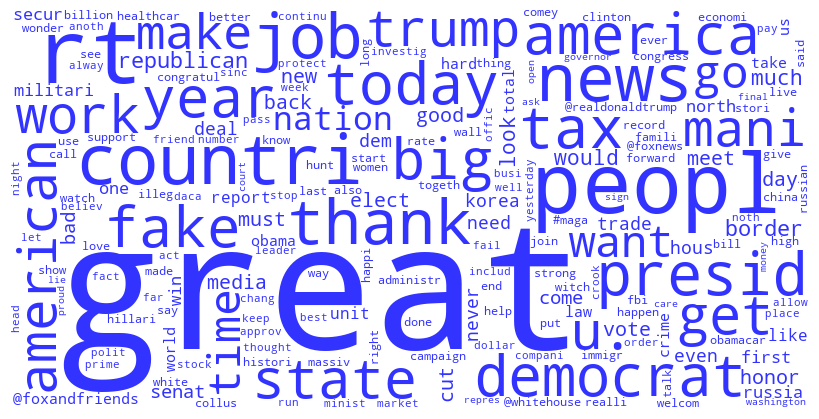

In [11]:
plt.figure(figsize=(8, 4))
plt.imshow(wc)
plt.axis("off")
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

You can also save this word cloud to disk.

In [12]:
wc.to_file(os.path.join(sdir, "wordcloud.png"))

## Weight DFMs

The DFM we've been working with so far has been mostly "unweighted." Each cell contains the raw count of a particular feature (i.e., a processed token) in a particular document. However, we did actually do _some_ weighting during preprocessing when we removed stop words and other "non-word" tokens. In effect, we set the weights of each of those tokens to zero. 

Weighting DFMs can be useful because very commonly used words often have high frequencies in a DFM, but are not very informative. In those cases, you may wish to weight those words down by applying a penalty to their counts in the DFM. This is the rationale for removing stop words. The stop word "the" is useful for making English language text read more smoothly, but it rarely contains substantive information about what the author is intending to convey. On the opposite end of the spectrum, you may have words that are used very infrequently (e.g., one time), and thus do not convey a lot of information in an entire corpus of documents. In many text analysis contexts, you may wish to find a "sweet spot" where you weight words more heavily when they are used a lot frequent but concentrated in a relatively smaller number of documents.

Here, we will cover two approaches to weighting that capture some of these ideas: "simple" weighting where we remove tokens that are not used much, and tf-idf weighting where we don't remove tokens, but rather boost or reduce the values in each cell of a DFM based on the usage patterns of tokens in the DFM.

### Trimming a DFM based on frequency

There are some words that appear in a corpus very infrequently, and thus contribute very little to an analysis of word usage. For example, the word "gentlemen" is used one time in one document in the (preprocessed) Trump tweet corpus. 

In [13]:
top_features[top_features.index == "gentlemen"]

gentlemen    1
dtype: int64

Including tokens like this in a DFM blows up the size of the DFM (more columns) and makes the DFM more sparse. This, in turn, can make statistical estimates more unstable and unreliable. In the next code chunk, we will "trim" our DFM by removing words that have low total term frequencies (TTFs, i.e., do not appear very many times overall), and that have low document frequencies (DFs, i.e., do not appear in many documents). By dropping them, we are effectively weighting them by zero.

In [14]:
# Calculate the document frequency for each feature
docf = (dfm_sparse > 0).sum(axis=0).A1
docf

array([1, 1, 1, ..., 1, 4, 1], shape=(5949,))

In [15]:
# Calculate the total term frequency for each feature
ttf = dfm_sparse.sum(axis=0).A1
ttf

array([1., 1., 1., ..., 1., 4., 1.], shape=(5949,))

If you want to preview the DF and the TTF for each feature in an easier-to-read format, you can use:

In [16]:
feature_ttf_df = pd.DataFrame({"docf": docf, "ttf": ttf}, index=vocabulary).astype(int)
feature_ttf_df

,docf,ttf
#afghanistan,1,1
#afghanstrategy,1,1
#ahca,1,1
#alconv2017,2,2
#amazonwashingtonpost,1,1
...,...,...
zito,1,1
zone,4,5
zoo,1,1
zte,4,4


Now, let's trim the DFM. We need to make a choice about how aggressively to do it. Let's try two options and see how much of a difference it makes. First, let's remove all features that appear only one time in the entire corpus. This means at we want to keep any feature that has a minimum total term frequency of 2.

In [17]:
import numpy as np

min_ttf = 2

cols_keep = np.where(ttf >= min_ttf)[0]
cols_keep

array([   3,    5,    6, ..., 5942, 5945, 5947], shape=(3230,))

Here, we can see that if we only keep features with at TTF of at least 2, we go from 5949 features to 3230 features. What if we get more aggressive, and keep only features appearing in at least 2 documents? This means that they need to have a minimum document frequency of 2. (Of course, mathematically, this also implies they will have a minimum total term frequency of 2.)

In [18]:
min_docf = 2

cols_keep = np.where(docf >= min_docf)[0]
cols_keep

array([   3,    5,    6, ..., 5942, 5945, 5947], shape=(3201,))

Now we're down to 3201 features. What if we are even more aggressive: keep features that appear in at least two documents, and at least 4 times total in the corpus?

In [19]:
min_docf = 2
min_ttf = 4

cols_keep = np.where((docf >= min_docf) & (ttf >= min_ttf))[0]
cols_keep

array([   6,   11,   43, ..., 5942, 5945, 5947], shape=(1975,))

Now, we're left with 1975 features. Which features are we keeping?

In [20]:
vocabulary_trimmed = [vocabulary[x] for x in cols_keep]
vocabulary_trimmed

['#americafirst',
 '#apec2017',
 '#cpac2018',
 '#draintheswamp',
 '#fake',
 '#fakenews',
 '#g20summit',
 '#g7summit',
 '#harvey',
 '#hurricaneharvey',
 '#icymi',
 '#kateslaw',
 '#lesm',
 '#maga',
 '#makeamericagreatagain',
 '#memorialday',
 '#ms13',
 '#noko',
 '#obamacare',
 '#potusabroad',
 '#prstrong',
 '#puertorico',
 '#repealandreplace',
 '#righttotry',
 '#taxday',
 '#taxreform',
 '#unga',
 '#usa',
 '#usaatunga',
 '#uswomensopen',
 '#weeklyaddress',
 '#wef18',
 '@abc',
 '@abeshinzo',
 '@cabinet',
 '@charliekirk11',
 '@cnn',
 '@dhsgov',
 '@donaldjtrumpjr',
 '@donnawr8',
 '@drudge_report',
 '@emmanuelmacron',
 '@erictrump',
 '@fema',
 '@flotus',
 '@foxandfriends',
 '@foxbusiness',
 '@foxnews',
 '@gop',
 '@gopchairwoman',
 '@gopleader',
 '@govabbott',
 '@ivankatrump',
 '@jessebwatters',
 '@judgejeanine',
 '@justintrudeau',
 '@kellyannepolls',
 '@loudobbs',
 '@mike_pence',
 '@narendramodi',
 '@nbcnews',
 '@netanyahu',
 '@nikkihaley',
 '@nytimes',
 '@pacificcommand',
 '@paulsperry_',
 '

Now, let's actually trim the DFM:

In [21]:
dfm_trimmed = dfm_sparse[:, cols_keep]
dfm_trimmed.shape

(3866, 1975)

### TF-IDF weighting

A more common (and less simple) approach to weighting is to use the TF-IDF weighting procedure. There are many variations of the weighting procedure, but here we'll calculate one variation by hand (using the lecture formula). Then we'll use an "out of the box" function available in the `sklearn` module.

For the manual calculation, we first calculate the inverse document frequency for each term (IDF):

In [22]:
idf = np.log(dfm_sparse.shape[0]/docf)
idf

array([8.25997566, 8.25997566, 8.25997566, ..., 8.25997566, 6.8736813 ,
       8.25997566], shape=(5949,))

Next, we multiply each value in the DFM by its feature's IDF:

In [23]:
dfm_tfidf = dfm_sparse.multiply(idf).tocsr()
print(dfm_tfidf)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 50274 stored elements and shape (3866, 5949)>
  Coords	Values
  (0, 96)	7.566828479208331
  (0, 151)	3.916170237914592
  (0, 883)	2.922437580066958
  (0, 1200)	5.081921829420331
  (0, 2533)	3.853256412504023
  (0, 3470)	3.0725898539275214
  (0, 3544)	2.8572982778959966
  (0, 4404)	5.315536680601836
  (0, 5424)	3.78263884529007
  (0, 5876)	3.8291588609249625
  (0, 5881)	2.826253656214037
  (1, 96)	7.566828479208331
  (1, 209)	8.259975659768276
  (1, 381)	7.161363371100166
  (1, 660)	8.259975659768276
  (1, 881)	2.7669142164277276
  (1, 1130)	5.215453222044853
  (1, 2943)	6.650537747334176
  (1, 3881)	4.676456721312166
  (1, 4732)	2.2221047398461384
  (2, 590)	3.58714682530637
  (2, 595)	7.161363371100166
  (2, 881)	2.7669142164277276
  (2, 1200)	5.081921829420331
  (2, 2533)	3.853256412504023
  :	:
  (3864, 2922)	6.8736812986483855
  (3864, 3570)	6.650537747334176
  (3864, 3833)	3.0396198346899514
  (3864, 3880)	8.25997565976

There are variations of TF-IDF weighting that attempt to deal with various technical issues, which we covered in lecture. For example, it is common to use "smoothed" inverse document frequency in many applications. It is straight forward to calculate:

In [24]:
sidf = np.log((1+dfm_sparse.shape[0])/(1+docf))+1
sidf

array([8.56708711, 8.56708711, 8.56708711, ..., 8.56708711, 7.65079638,
       8.56708711], shape=(5949,))

Now, let's weight the DFM using tf-idf where idf is "smoothed":

In [25]:
dfm_tfidf_sm = dfm_sparse.multiply(sidf).tocsr()
print(dfm_tfidf_sm)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 50274 stored elements and shape (3866, 5949)>
  Coords	Values
  (0, 96)	8.161622002939186
  (0, 151)	4.903525464917705
  (0, 883)	3.917900039642486
  (0, 1200)	6.041358466739096
  (0, 2533)	4.841393683810699
  (0, 3470)	4.067277440717087
  (0, 3544)	3.853062520147178
  (0, 4404)	6.264502018053306
  (0, 5424)	4.771597921875157
  (0, 5876)	4.81758303511698
  (0, 5881)	3.822154982684102
  (1, 96)	8.161622002939186
  (1, 209)	8.567087111047352
  (1, 381)	7.873939930487406
  (1, 660)	8.567087111047352
  (1, 881)	3.7630660663140953
  (1, 1130)	6.169191838248981
  (1, 2943)	7.468474822379242
  (1, 3881)	5.649316378963072
  (1, 4732)	3.219979580329883
  (2, 590)	4.578103064483077
  (2, 595)	7.873939930487406
  (2, 881)	3.7630660663140953
  (2, 1200)	6.041358466739096
  (2, 2533)	4.841393683810699
  :	:
  (3864, 2922)	7.6507963791731965
  (3864, 3570)	7.468474822379242
  (3864, 3833)	4.034487617894095
  (3864, 3880)	8.567087111047352

Fortunately, the `sklearn` module has a `TfidfTransformer` class that allows you to perform tf-idf weighting on a DFM you already have as a sparse matrix. Note that this process yields tf-idf weighting with smoothed idf. 

In [26]:
from sklearn.feature_extraction.text import TfidfTransformer

# Step 1: initialise a `TfidfTransformer` object
# Note: we will not normalise, so select norm=None
transformer = TfidfTransformer(norm=None)
# Step 2: perform the tf-idf weighting on the sparse DFM
dfm_tfidf = transformer.fit_transform(dfm_sparse)

You can see that the values reported are the same as those we calculated by hand above.

In [27]:
print(dfm_tfidf)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 50274 stored elements and shape (3866, 5949)>
  Coords	Values
  (0, 96)	8.161622002939186
  (0, 151)	4.903525464917705
  (0, 883)	3.917900039642486
  (0, 1200)	6.041358466739096
  (0, 2533)	4.841393683810699
  (0, 3470)	4.067277440717087
  (0, 3544)	3.853062520147178
  (0, 4404)	6.264502018053306
  (0, 5424)	4.771597921875157
  (0, 5876)	4.81758303511698
  (0, 5881)	3.822154982684102
  (1, 96)	8.161622002939186
  (1, 209)	8.567087111047352
  (1, 381)	7.873939930487406
  (1, 660)	8.567087111047352
  (1, 881)	3.7630660663140953
  (1, 1130)	6.169191838248981
  (1, 2943)	7.468474822379242
  (1, 3881)	5.649316378963072
  (1, 4732)	3.219979580329883
  (2, 590)	4.578103064483077
  (2, 595)	7.873939930487406
  (2, 881)	3.7630660663140953
  (2, 1200)	6.041358466739096
  (2, 2533)	4.841393683810699
  :	:
  (3864, 2922)	7.6507963791731965
  (3864, 3570)	7.468474822379242
  (3864, 3833)	4.034487617894095
  (3864, 3880)	8.567087111047352

Finally, let's see if re-weighting the DFM using tf-idf changes which words are considered the (weighted) top words. We'll do this by plotting a word cloud.

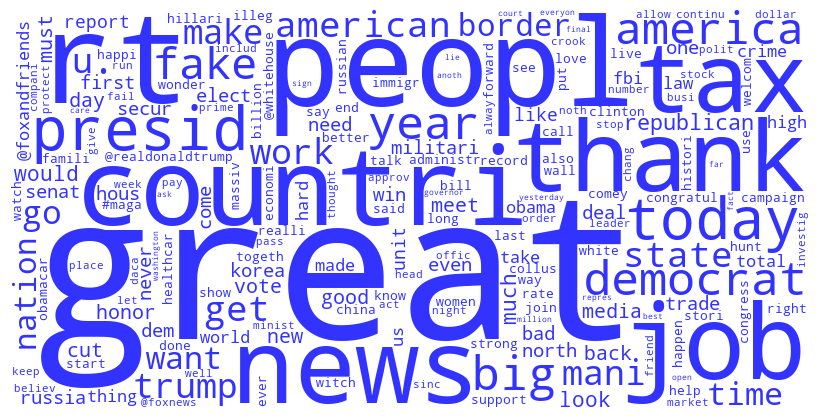

In [28]:
top_features2 = dfm_tfidf.sum(axis = 0).A1
top_features2 = pd.Series(top_features2, index=vocabulary).astype(int)

wc = wordcloud.WordCloud(width=800,
                         height=400,
                         background_color="white",
                         relative_scaling = 1,
                         max_words=200, 
                         random_state=42)

wc = wc.generate_from_frequencies(top_features2)

wc = wc.recolor(color_func=lambda *args, **kwargs: (51,51,255))

plt.figure(figsize=(8, 4))
plt.imshow(wc)
plt.axis("off")
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()